In [1]:
# import necessary packages

import pandas as pd
import numpy as np
import requests
import json
import argparse
import collections
import csv
from glob import glob
import simplejson as json
import matplotlib.pyplot as plt
import time
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn import tree


%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
# Lets take a quick look at the data
start_time = time.time()
business = pd.read_csv('/home/muzamil/Dataset/yelp/csv/yelp_academic_dataset_business.csv', low_memory = False)
print("This took", time.time() - start_time, "seconds to run.")

This took 3.6309406757354736 seconds to run.


In [3]:
print("Columns in business data file are:"+str(len(business.columns)))
for i in business.columns:
    print(i)

Columns in business data file are:60
name
attributes.BYOBCorkage
attributes.BikeParking
attributes.BusinessAcceptsBitcoin
state
hours.Wednesday
attributes.RestaurantsTakeOut
longitude
attributes.CoatCheck
attributes.BusinessParking
attributes.Music
attributes
attributes.BYOB
attributes.BusinessAcceptsCreditCards
attributes.OutdoorSeating
attributes.RestaurantsGoodForGroups
stars
attributes.Alcohol
postal_code
attributes.RestaurantsAttire
hours.Saturday
attributes.GoodForKids
hours.Sunday
attributes.AgesAllowed
latitude
attributes.HasTV
attributes.HairSpecializesIn
attributes.ByAppointmentOnly
attributes.Open24Hours
attributes.RestaurantsDelivery
attributes.NoiseLevel
address
attributes.DriveThru
attributes.RestaurantsCounterService
hours.Friday
attributes.WheelchairAccessible
attributes.Ambience
attributes.RestaurantsPriceRange2
attributes.AcceptsInsurance
hours.Monday
attributes.GoodForMeal
attributes.HappyHour
business_id
attributes.Smoking
attributes.Corkage
attributes.GoodForDancin

In [5]:
#business_az = business.loc[business["state"] == 'AZ']

In [5]:
# Lets load in our user data
start_time = time.time()
user = pd.read_csv('/home/muzamil/Dataset/yelp/csv/yelp_academic_dataset_user.csv', low_memory = False)
print("This took", time.time() - start_time, "seconds to run.")

This took 31.068610429763794 seconds to run.


In [6]:
print("Columns in user data file are:"+str(len(user.columns)))
for i in user.columns:
    print(i)

Columns in user data file are:22
compliment_writer
compliment_list
compliment_profile
compliment_cool
compliment_photos
compliment_cute
name
yelping_since
useful
review_count
elite
fans
compliment_plain
cool
compliment_funny
user_id
average_stars
compliment_hot
funny
compliment_more
friends
compliment_note


In [ ]:
# This initially was setup to load in the reviews dataset.
# However, the dataset is massive and both computationally and time conusming to run and load.
# For this project, we're going to focus on just data from the state of Arizona.

# Initially, this ran using the below code:
# reviews = pd.read_csv('reviews.csv', low_memory = False)

# I created a new csv file already for the Arizona reviews and that is what will be called and used moving forward.


reviews = pd.read_csv('/home/muzamil/Dataset/yelp/csv/yelp_academic_dataset_review.csv', low_memory = False)

In [6]:
print("Columns in user data file are:"+str(len(reviews.columns)))
for i in reviews.columns:
    print(i)

Columns in user data file are:9
date
funny
business_id
user_id
useful
stars
text
cool
review_id


In [8]:
# this file is very large. to make processing easier moving forward, we're going to work with just AZ restaurant reviews. 
# this removal process will take place below
reviews.head()

,Unnamed: 0,date,funny,business_id,user_id,useful,stars,text,cool,review_id
0,1,2013-12-07 03:16:52,1,lbrU8StCq3yDfr-QMnGrmQ,nIJD_7ZXHq-FX8byPMOkMQ,1,1.0,I am actually horrified this place is still in...,0,UmFMZ8PyXZTY2QcwzsfQYA
1,6,2015-11-05 23:11:05,0,Pthe4qk5xh4n-ef-9bvMSg,aq_ZxGHiri48TUXJlpRkCQ,1,5.0,"Really good place with simple decor, amazing f...",0,ZayJ1zWyWgY9S_TRLT_y9Q
2,8,2015-02-16 06:48:47,0,e_BiI4ej1CW1F0EyVLr-FQ,P6apihD4ASf1vpPxHODxAQ,0,5.0,Most delicious authentic Italian I've had in t...,0,JA-xnyHytKiOIHl_ztnK9Q
3,9,2009-10-13 04:16:41,0,Ws8V970-mQt2X9CwCuT5zw,jOERvhmK6_lo_XGUBPws_w,3,4.0,I have been here twice. Very nice and laid bac...,1,z4BCgTkfNtCu4XY5Lp97ww
4,13,2016-06-11 22:00:11,0,Ns4tjgLfqR1qawGlNFROBA,qftVgPj_kRTildMDjwiqtg,0,5.0,Everything that my husband and I tried today w...,0,QCxPzh7cuxJrLd6A_UTbpw


In [9]:
# Lets begin cleaning the data
# Begin with dropping data where business_id or user_id is null

business.dropna(subset = ['business_id'], how = 'any', inplace = True)
reviews.dropna(subset = ['business_id', 'user_id'], how = 'any', inplace = True)
user.dropna(subset = ['user_id'], how = 'any', inplace = True)

In [10]:
rest = business['categories'].str.contains('Restaurants')
food = business['categories'].str.contains('Food')
bus_df = business[rest & food]
# number of businesses that have food and restaurant in their category
bus_df['categories'].count()

23487

In [13]:
bus_df = bus_df[bus_df['state'].str.contains('AZ')]
bus_df.head()

,name,attributes.BYOBCorkage,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,state,hours.Wednesday,attributes.RestaurantsTakeOut,longitude,attributes.CoatCheck,attributes.BusinessParking,...,categories,hours.Tuesday,attributes.DogsAllowed,review_count,attributes.BestNights,hours.Thursday,hours,attributes.WiFi,attributes.DietaryRestrictions,attributes.Caters
33,Wetzel's Pretzels,NaN,True,NaN,AZ,10:0-21:0,True,-111.983533,NaN,"{'garage': False, 'street': False, 'validated'...",...,"Food, Pretzels, Bakeries, Fast Food, Restaurants",10:0-21:0,NaN,10,NaN,10:0-21:0,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",NaN,NaN,NaN
46,Boomer's Sweet Home Chicago,NaN,NaN,NaN,AZ,NaN,True,-112.187028,NaN,"{'garage': False, 'street': False, 'validated'...",...,"Burgers, Fast Food, American (New), Restaurant...",NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN
59,Tzikii Food Truck,NaN,NaN,NaN,AZ,NaN,False,-111.963660,NaN,NaN,...,"Restaurants, Egyptian, Food Trucks, Food, Midd...",NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
89,Papaya Thai,NaN,True,NaN,AZ,11:0-21:0,True,-111.772890,NaN,"{'garage': False, 'street': False, 'validated'...",...,"Food, Ethnic Food, Specialty Food, Restaurants...",11:0-21:0,NaN,130,NaN,11:0-21:0,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",u'no',NaN,False
108,Sugar Bowl,NaN,True,NaN,AZ,11:0-22:0,True,-111.925933,NaN,"{'garage': False, 'street': True, 'validated':...",...,"Ice Cream & Frozen Yogurt, Sandwiches, Food, A...",11:0-22:0,False,720,NaN,11:0-22:0,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",u'no',NaN,False


In [14]:
bus_ids = bus_df['business_id']

In [15]:
review = reviews[reviews.business_id.isin(bus_ids)]

In [16]:
# Only keep user_id data that have more than one review

review = review[review.groupby('user_id').user_id.transform(len) > 1]
# let's verify this worked by taking the minimum amount of user_id counts
print('The minimum amount of reviews per user is {}'.format(np.min(review.groupby('user_id')['business_id'].count())))

The minimum amount of reviews per user is 2


In [17]:
del reviews
review.head()

,Unnamed: 0,date,funny,business_id,user_id,useful,stars,text,cool,review_id
3,9,2009-10-13 04:16:41,0,Ws8V970-mQt2X9CwCuT5zw,jOERvhmK6_lo_XGUBPws_w,3,4.0,I have been here twice. Very nice and laid bac...,1,z4BCgTkfNtCu4XY5Lp97ww
4,13,2016-06-11 22:00:11,0,Ns4tjgLfqR1qawGlNFROBA,qftVgPj_kRTildMDjwiqtg,0,5.0,Everything that my husband and I tried today w...,0,QCxPzh7cuxJrLd6A_UTbpw
6,22,2016-12-04 03:15:21,19,9Jo1pu0y2zU6ktiwQm6gNA,A0j21z2Q1HGic7jW6e9h7A,24,4.0,"Coconut's Fish Cafe is a fantastic, Five Stars...",20,sgTnHfeaEvyOoWX4TCgkuQ
11,36,2011-01-08 23:13:25,0,WUmosjOxt_8nWByHgm8Kkg,6UR0kNe3C-ivlF2x1fPHNQ,0,5.0,Who knew?\n \nI did! \n\nI remember eating man...,0,-cRD6URpwks2GvP6qy8x4Q
25,83,2018-02-01 19:18:02,0,6ZIHxvFTHC1pvAzAS0uLDA,LPva2snYp0Fdu8Z1QIXLiA,1,4.0,What can I say? The bread is made daily and t...,0,ydmLJUsQTKrUMmM1hSFjFg


In [18]:
bus_df.head(10)['categories']

33      Food, Pretzels, Bakeries, Fast Food, Restaurants
46     Burgers, Fast Food, American (New), Restaurant...
59     Restaurants, Egyptian, Food Trucks, Food, Midd...
89     Food, Ethnic Food, Specialty Food, Restaurants...
108    Ice Cream & Frozen Yogurt, Sandwiches, Food, A...
151                   Restaurants, Sandwiches, Fast Food
156          Mexican, Restaurants, Food, Salad, Desserts
227    Specialty Food, Vietnamese, Food, Restaurants,...
253    Restaurants, Fast Food, Chicken Wings, Chicken...
260     Hot Dogs, Fast Food, Restaurants, Middle Eastern
Name: categories, dtype: object

In [19]:
categories = ', '.join(list(bus_df['categories'].unique()))
categories = categories.split(', ')
categories[:10]

['Food',
 'Pretzels',
 'Bakeries',
 'Fast Food',
 'Restaurants',
 'Burgers',
 'Fast Food',
 'American (New)',
 'Restaurants',
 'Hot Dogs']

In [20]:
from collections import Counter, defaultdict
c = Counter(categories)
c.most_common(50)

[('Restaurants', 3749),
 ('Food', 2989),
 ('Fast Food', 1034),
 ('Sandwiches', 746),
 ('Breakfast & Brunch', 692),
 ('Coffee & Tea', 634),
 ('American (Traditional)', 530),
 ('Burgers', 510),
 ('Mexican', 504),
 ('Nightlife', 459),
 ('American (New)', 453),
 ('Bars', 432),
 ('Desserts', 386),
 ('Specialty Food', 368),
 ('Bakeries', 345),
 ('Pizza', 341),
 ('Event Planning & Services', 326),
 ('Salad', 318),
 ('Cafes', 306),
 ('Ice Cream & Frozen Yogurt', 298),
 ('Beer', 283),
 ('Wine & Spirits', 283),
 ('Caterers', 277),
 ('Juice Bars & Smoothies', 276),
 ('Delis', 267),
 ('Italian', 223),
 ('Food Trucks', 221),
 ('Chicken Wings', 211),
 ('Tacos', 178),
 ('Food Delivery Services', 162),
 ('Seafood', 151),
 ('Gluten-Free', 142),
 ('Vegetarian', 123),
 ('Asian Fusion', 119),
 ('Vegan', 116),
 ('Ethnic Food', 115),
 ('Comfort Food', 110),
 ('Grocery', 106),
 ('Chinese', 105),
 ('Hot Dogs', 104),
 ('Barbeque', 103),
 ('Mediterranean', 100),
 ('Wine Bars', 95),
 ('Sports Bars', 93),
 ('Bage

In [21]:
# Lets identify the most popular cuisines. This will be helpful for future models
cuisine = 'American|Chinese|Italian|Japanese|Mexican|Asian Fusion|Thai|Korean|Mediterranean'
bus_df['cuisine'] = bus_df['categories'].str.findall(cuisine)

In [22]:
bus_df['cuisine'] = bus_df['cuisine'].map(lambda x: list(x))
bus_df['cuisine'] = bus_df['cuisine'].map(lambda x: ['Others'] if x == [] else x)

In [23]:
bus_df.cuisine.head(20)

33                    [Others]
46                  [American]
59                    [Others]
89                      [Thai]
108                 [American]
151                   [Others]
156                  [Mexican]
227             [Asian Fusion]
253                   [Others]
260                   [Others]
321                  [Mexican]
329                   [Others]
351                   [Others]
355    [Chinese, Asian Fusion]
588                  [Mexican]
621                   [Others]
626                   [Others]
696                   [Others]
733        [Mexican, American]
759                 [American]
Name: cuisine, dtype: object

In [24]:
# Remove redundant entries

bus_df['cuisine'] = bus_df['cuisine'].map(lambda x: list(dict.fromkeys(x)))
bus_df['cuisine'] = bus_df['cuisine'].map(', '.join) # convert list of string to string
bus_df['cuisine'].head(10)

33           Others
46         American
59           Others
89             Thai
108        American
151          Others
156         Mexican
227    Asian Fusion
253          Others
260          Others
Name: cuisine, dtype: object

In [25]:
bus_df.cuisine.unique()

array(['Others', 'American', 'Thai', 'Mexican', 'Asian Fusion',
       'Chinese, Asian Fusion', 'Mexican, American', 'Italian, American',
       'Korean', 'American, Italian', 'Chinese', 'Italian',
       'Mediterranean', 'Japanese', 'Asian Fusion, Korean',
       'Asian Fusion, Chinese', 'Asian Fusion, Chinese, Japanese',
       'American, Mediterranean', 'American, Mexican',
       'Mediterranean, American', 'American, Asian Fusion',
       'Asian Fusion, Korean, Chinese, Thai', 'Mexican, Asian Fusion',
       'Asian Fusion, Mediterranean', 'Chinese, Thai',
       'Japanese, Asian Fusion', 'Thai, Asian Fusion',
       'Mexican, Asian Fusion, American',
       'Asian Fusion, Italian, Japanese, Chinese',
       'Asian Fusion, American, Mexican',
       'Japanese, Asian Fusion, Korean', 'Asian Fusion, Italian',
       'American, Mediterranean, Mexican', 'Korean, Japanese',
       'Mexican, Italian', 'American, Japanese, Asian Fusion',
       'Asian Fusion, Italian, Japanese',
       'It

In [26]:
bus_df['cuisine'].iloc[np.where(bus_df['cuisine'].str.contains('Asian Fusion'))] = 'Asian Fusion'

/home/muzamil/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
bus_df.cuisine.unique()

array(['Others', 'American', 'Thai', 'Mexican', 'Asian Fusion',
       'Mexican, American', 'Italian, American', 'Korean',
       'American, Italian', 'Chinese', 'Italian', 'Mediterranean',
       'Japanese', 'American, Mediterranean', 'American, Mexican',
       'Mediterranean, American', 'Chinese, Thai',
       'American, Mediterranean, Mexican', 'Korean, Japanese',
       'Mexican, Italian', 'Italian, Mediterranean, American',
       'Italian, American, Mediterranean', 'Mediterranean, Italian',
       'Japanese, Korean', 'Italian, Mediterranean', 'Italian, Chinese',
       'Japanese, Mexican', 'Mexican, Mediterranean',
       'Japanese, American', 'Italian, Mexican', 'Chinese, Japanese',
       'American, Italian, Mexican', 'Mexican, Japanese',
       'Japanese, American, Mexican', 'Chinese, American',
       'Japanese, Chinese', 'American, Italian, Mediterranean'],
      dtype=object)

In [29]:
bus_df = bus_df.reset_index(drop = True)
bus_df.index += 1
bus_df.head()

,name,attributes.BYOBCorkage,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,state,hours.Wednesday,attributes.RestaurantsTakeOut,longitude,attributes.CoatCheck,attributes.BusinessParking,...,hours.Tuesday,attributes.DogsAllowed,review_count,attributes.BestNights,hours.Thursday,hours,attributes.WiFi,attributes.DietaryRestrictions,attributes.Caters,cuisine
1,Wetzel's Pretzels,NaN,True,NaN,AZ,10:0-21:0,True,-111.983533,NaN,"{'garage': False, 'street': False, 'validated'...",...,10:0-21:0,NaN,10,NaN,10:0-21:0,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",NaN,NaN,NaN,Others
2,Boomer's Sweet Home Chicago,NaN,NaN,NaN,AZ,NaN,True,-112.187028,NaN,"{'garage': False, 'street': False, 'validated'...",...,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,American
3,Tzikii Food Truck,NaN,NaN,NaN,AZ,NaN,False,-111.963660,NaN,NaN,...,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,Others
4,Papaya Thai,NaN,True,NaN,AZ,11:0-21:0,True,-111.772890,NaN,"{'garage': False, 'street': False, 'validated'...",...,11:0-21:0,NaN,130,NaN,11:0-21:0,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",u'no',NaN,False,Thai
5,Sugar Bowl,NaN,True,NaN,AZ,11:0-22:0,True,-111.925933,NaN,"{'garage': False, 'street': True, 'validated':...",...,11:0-22:0,False,720,NaN,11:0-22:0,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",u'no',NaN,False,American


In [30]:
bus_df.columns

Index(['name', 'attributes.BYOBCorkage', 'attributes.BikeParking',
       'attributes.BusinessAcceptsBitcoin', 'state', 'hours.Wednesday',
       'attributes.RestaurantsTakeOut', 'longitude', 'attributes.CoatCheck',
       'attributes.BusinessParking', 'attributes.Music', 'attributes',
       'attributes.BYOB', 'attributes.BusinessAcceptsCreditCards',
       'attributes.OutdoorSeating', 'attributes.RestaurantsGoodForGroups',
       'stars', 'attributes.Alcohol', 'postal_code',
       'attributes.RestaurantsAttire', 'hours.Saturday',
       'attributes.GoodForKids', 'hours.Sunday', 'attributes.AgesAllowed',
       'latitude', 'attributes.HasTV', 'attributes.HairSpecializesIn',
       'attributes.ByAppointmentOnly', 'attributes.Open24Hours',
       'attributes.RestaurantsDelivery', 'attributes.NoiseLevel', 'address',
       'attributes.DriveThru', 'attributes.RestaurantsCounterService',
       'hours.Friday', 'attributes.WheelchairAccessible',
       'attributes.Ambience', 'attributes.Re

In [31]:
# Lets save a csv of the cleaned business review data.
bus_df.to_csv('data/yelp/csv/yelp_rec_sys/restaurants_final.csv')

In [32]:
user.head()

,compliment_writer,compliment_list,compliment_profile,compliment_cool,compliment_photos,compliment_cute,name,yelping_since,useful,review_count,...,compliment_plain,cool,compliment_funny,user_id,average_stars,compliment_hot,funny,compliment_more,friends,compliment_note
0,10,1,1,22,0,0,Rafael,2007-07-06 03:27:11,628,553,...,15,227,22,ntlvfPzc8eglqvk92iDIAw,3.57,3,225,2,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",11
1,21,1,5,63,5,2,Michelle,2008-04-28 01:29:25,790,564,...,37,400,63,FOBRPlBHa3WPHFB5qYDlVg,3.84,36,316,4,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",33
2,4,0,0,17,1,1,Martin,2008-08-28 23:40:05,151,60,...,7,103,17,zZUnPeh2hEp0WydbAZEOOg,3.44,9,125,6,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",3
3,2,0,0,7,0,0,John,2008-09-20 00:08:14,233,206,...,14,84,7,QaELAmRcDc5TfJEylaaP8g,3.08,2,160,1,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",7
4,19,1,2,31,31,1,Anne,2008-08-09 00:30:27,1265,485,...,28,512,31,xvu8G900tezTzbbfqmTKvA,4.37,8,400,9,"3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",22


In [33]:
review.head()

,Unnamed: 0,date,funny,business_id,user_id,useful,stars,text,cool,review_id
3,9,2009-10-13 04:16:41,0,Ws8V970-mQt2X9CwCuT5zw,jOERvhmK6_lo_XGUBPws_w,3,4.0,I have been here twice. Very nice and laid bac...,1,z4BCgTkfNtCu4XY5Lp97ww
4,13,2016-06-11 22:00:11,0,Ns4tjgLfqR1qawGlNFROBA,qftVgPj_kRTildMDjwiqtg,0,5.0,Everything that my husband and I tried today w...,0,QCxPzh7cuxJrLd6A_UTbpw
6,22,2016-12-04 03:15:21,19,9Jo1pu0y2zU6ktiwQm6gNA,A0j21z2Q1HGic7jW6e9h7A,24,4.0,"Coconut's Fish Cafe is a fantastic, Five Stars...",20,sgTnHfeaEvyOoWX4TCgkuQ
11,36,2011-01-08 23:13:25,0,WUmosjOxt_8nWByHgm8Kkg,6UR0kNe3C-ivlF2x1fPHNQ,0,5.0,Who knew?\n \nI did! \n\nI remember eating man...,0,-cRD6URpwks2GvP6qy8x4Q
25,83,2018-02-01 19:18:02,0,6ZIHxvFTHC1pvAzAS0uLDA,LPva2snYp0Fdu8Z1QIXLiA,1,4.0,What can I say? The bread is made daily and t...,0,ydmLJUsQTKrUMmM1hSFjFg


In [35]:
# Lets identify what features are null values
def feature_with_nan(df):
    all_nan = df.columns[df.isnull().all()].tolist()
    some_nan = df.columns[df.isnull().any()].tolist()
    print("All NaN Features: ", len(all_nan), all_nan, "Some NaN Features: ", len(some_nan), some_nan)
    return all_nan, some_nan

In [36]:
all_nan, some_nan = feature_with_nan(bus_df)

All NaN Features:  2 ['attributes.HairSpecializesIn', 'attributes.Open24Hours'] Some NaN Features:  50 ['attributes.BYOBCorkage', 'attributes.BikeParking', 'attributes.BusinessAcceptsBitcoin', 'hours.Wednesday', 'attributes.RestaurantsTakeOut', 'attributes.CoatCheck', 'attributes.BusinessParking', 'attributes.Music', 'attributes', 'attributes.BYOB', 'attributes.BusinessAcceptsCreditCards', 'attributes.OutdoorSeating', 'attributes.RestaurantsGoodForGroups', 'attributes.Alcohol', 'postal_code', 'attributes.RestaurantsAttire', 'hours.Saturday', 'attributes.GoodForKids', 'hours.Sunday', 'attributes.AgesAllowed', 'attributes.HasTV', 'attributes.HairSpecializesIn', 'attributes.ByAppointmentOnly', 'attributes.Open24Hours', 'attributes.RestaurantsDelivery', 'attributes.NoiseLevel', 'address', 'attributes.DriveThru', 'attributes.RestaurantsCounterService', 'hours.Friday', 'attributes.WheelchairAccessible', 'attributes.Ambience', 'attributes.RestaurantsPriceRange2', 'attributes.AcceptsInsurance'

In [40]:
bus_df.drop(columns = ['attributes', 'hours','address','attributes.HairSpecializesIn', 'attributes.Open24Hours',
                       'attributes.AcceptsInsurance', 'attributes.AgesAllowed', 'attributes.Alcohol', 'attributes.Ambience',
                       'attributes.BYOB', 'attributes.BYOBCorkage', 'attributes.BestNights', 'attributes.BikeParking',
                       'attributes.BusinessAcceptsBitcoin', 'attributes.BusinessAcceptsCreditCards', 'attributes.BusinessParking',
                       'attributes.ByAppointmentOnly', 'attributes.Caters', 'attributes.CoatCheck', 'attributes.Corkage',
                       'attributes.DietaryRestrictions', 'attributes.GoodForDancing', 'attributes.HairSpecializesIn', 'attributes.HappyHour',
                       'attributes.Music','attributes.Open24Hours','attributes.RestaurantsCounterService','hours.Friday', 'hours.Monday',
                       'hours.Saturday', 'hours.Sunday', 'hours.Thursday', 'hours.Tuesday', 'hours.Wednesday', 'postal_code'])
bus_df.head()

,name,attributes.BYOBCorkage,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,state,hours.Wednesday,attributes.RestaurantsTakeOut,longitude,attributes.CoatCheck,attributes.BusinessParking,...,hours.Tuesday,attributes.DogsAllowed,review_count,attributes.BestNights,hours.Thursday,hours,attributes.WiFi,attributes.DietaryRestrictions,attributes.Caters,cuisine
1,Wetzel's Pretzels,NaN,True,NaN,AZ,10:0-21:0,True,-111.983533,NaN,"{'garage': False, 'street': False, 'validated'...",...,10:0-21:0,NaN,10,NaN,10:0-21:0,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",NaN,NaN,NaN,Others
2,Boomer's Sweet Home Chicago,NaN,NaN,NaN,AZ,NaN,True,-112.187028,NaN,"{'garage': False, 'street': False, 'validated'...",...,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,American
3,Tzikii Food Truck,NaN,NaN,NaN,AZ,NaN,False,-111.963660,NaN,NaN,...,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,Others
4,Papaya Thai,NaN,True,NaN,AZ,11:0-21:0,True,-111.772890,NaN,"{'garage': False, 'street': False, 'validated'...",...,11:0-21:0,NaN,130,NaN,11:0-21:0,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",u'no',NaN,False,Thai
5,Sugar Bowl,NaN,True,NaN,AZ,11:0-22:0,True,-111.925933,NaN,"{'garage': False, 'street': True, 'validated':...",...,11:0-22:0,False,720,NaN,11:0-22:0,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",u'no',NaN,False,American


In [41]:
def red_review(df, business_list):
    # Drop columns where business_id or user_id is null
    df.dropna(subset = ['business_id','user_id'], how = 'any', inplace = True)
    
    # Restrict to businesses that are restaurants
    df = df[df['business_id'].isin(business_list)]
    
    # Only keep user_id's with more than one review
    df = df[df.groupby('user_id').user_id.transform(len) > 1]
    
    # Verify this worked by taking the minimum amount of user_id counts
    print('The minimum amount of reviews per user is {}'.format(np.min(df.groupby('user_id')['business_id'].count())))
    return df

In [43]:
# Create df
rest_reviews = red_review(review, bus_df['business_id'])

# Report if there are null values
_, _ = feat_with_nan(rest_reviews)

rest_reviews['review_date'] = pd.to_datetime(rest_reviews['date'])
rest_reviews['review_year'] = rest_reviews['review_date'].dt.year
rest_reviews['review_month'] = rest_reviews['review_date'].dt.month
rest_reviews['review_weekday'] = rest_reviews['review_date'].dt.day_name()

rename_cols = {'cool': 'review_cool','funny':'review_funny','stars':'review_stars','useful':'review_useful'}
rest_reviews.rename(columns = rename_cols, inplace = True)
review_cols_to_drop = ['text', 'review_date', 'date']
rest_reviews.drop(review_cols_to_drop, axis = 1, inplace = True)

The minimum amount of reviews per user is 2
All NaN Features:  0 [] Some NaN Features:  0 []


In [44]:
rest_reviews.head()

,Unnamed: 0,review_funny,business_id,user_id,review_useful,review_stars,review_cool,review_id,review_year,review_month,review_weekday
3,9,0,Ws8V970-mQt2X9CwCuT5zw,jOERvhmK6_lo_XGUBPws_w,3,4.0,1,z4BCgTkfNtCu4XY5Lp97ww,2009,10,Tuesday
4,13,0,Ns4tjgLfqR1qawGlNFROBA,qftVgPj_kRTildMDjwiqtg,0,5.0,0,QCxPzh7cuxJrLd6A_UTbpw,2016,6,Saturday
6,22,19,9Jo1pu0y2zU6ktiwQm6gNA,A0j21z2Q1HGic7jW6e9h7A,24,4.0,20,sgTnHfeaEvyOoWX4TCgkuQ,2016,12,Sunday
11,36,0,WUmosjOxt_8nWByHgm8Kkg,6UR0kNe3C-ivlF2x1fPHNQ,0,5.0,0,-cRD6URpwks2GvP6qy8x4Q,2011,1,Saturday
25,83,0,6ZIHxvFTHC1pvAzAS0uLDA,LPva2snYp0Fdu8Z1QIXLiA,1,4.0,0,ydmLJUsQTKrUMmM1hSFjFg,2018,2,Thursday


In [45]:
rest_reviews.to_csv('data/yelp/csv/yelp_rec_sys/restaurant_reviews_final.csv')

In [46]:
# add user df
users_reviews = user[user['user_id'].isin(rest_reviews['user_id'])].copy()

In [47]:
users_reviews.head()

,compliment_writer,compliment_list,compliment_profile,compliment_cool,compliment_photos,compliment_cute,name,yelping_since,useful,review_count,...,compliment_plain,cool,compliment_funny,user_id,average_stars,compliment_hot,funny,compliment_more,friends,compliment_note
0,10,1,1,22,0,0,Rafael,2007-07-06 03:27:11,628,553,...,15,227,22,ntlvfPzc8eglqvk92iDIAw,3.57,3,225,2,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",11
1,21,1,5,63,5,2,Michelle,2008-04-28 01:29:25,790,564,...,37,400,63,FOBRPlBHa3WPHFB5qYDlVg,3.84,36,316,4,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",33
13,0,0,0,1,0,1,TJ,2009-01-02 19:09:32,16,6,...,0,14,1,HwPGLzF_uXB3MF8bc5u5dg,4.50,0,9,1,"XEHZoTDWjw3w-gcQyYIe4g, KyeCA8acObsNpgU3fH0W0A...",0
17,0,0,0,0,0,0,Drew,2011-04-04 01:57:51,17,15,...,1,1,0,6bbHSJ0PrgSxh7e5nigKMw,2.21,0,7,0,"P7X4XYW_bmEo_ccaH5Yxrw, JiaJJzXFc6vBPke9v_V9Uw...",1
18,6,0,0,10,0,1,Rebecca,2008-10-26 03:13:07,252,106,...,6,109,10,4VmuXuSRhv5UxYUy3tMpiQ,3.88,5,109,3,"ZIoSgXGRMfq39eW6-FFWQA, ZucM8Rc7m4HguYM4kaoXSg...",4


In [48]:
user_vars_to_remove = ['compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 
                   'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 
                   'compliment_writer', 'elite', 'fans', 'friends', 'funny', 'name']

users_reviews['yelping_since'] = pd.to_datetime(users_reviews['yelping_since'])
users_reviews['yelping_since'] = users_reviews['yelping_since'].dt.year


users_reviews.drop(user_vars_to_remove, axis = 1, inplace = True)

In [49]:
users_reviews.head()

,yelping_since,useful,review_count,cool,user_id,average_stars
0,2007,628,553,227,ntlvfPzc8eglqvk92iDIAw,3.57
1,2008,790,564,400,FOBRPlBHa3WPHFB5qYDlVg,3.84
13,2009,16,6,14,HwPGLzF_uXB3MF8bc5u5dg,4.50
17,2011,17,15,1,6bbHSJ0PrgSxh7e5nigKMw,2.21
18,2008,252,106,109,4VmuXuSRhv5UxYUy3tMpiQ,3.88


In [50]:
users_reviews.to_csv('data/yelp/csv/yelp_rec_sys/user_final.csv')

In [51]:
# Now that we have user data that coincides only in our review df, and have cleaned our business df, 
# its time to merge the df's into one

df_merged = rest_reviews.merge(bus_df, how = 'left', on = 'business_id')

In [52]:
df_merged = df_merged.merge(users_reviews, how = 'left', on = 'user_id')

In [53]:
df_merged = df_merged.rename(columns = {'review_count_x':'bus_review_count', 'review_count_y':'user_review_count',
                                        'stars':'bus_stars','average_stars':'user_average_stars'})

In [54]:
df_merged.head()

,Unnamed: 0,review_funny,business_id,user_id,review_useful,review_stars,review_cool,review_id,review_year,review_month,...,hours,attributes.WiFi,attributes.DietaryRestrictions,attributes.Caters,cuisine,yelping_since,useful,user_review_count,cool,user_average_stars
0,9,0,Ws8V970-mQt2X9CwCuT5zw,jOERvhmK6_lo_XGUBPws_w,3,4.0,1,z4BCgTkfNtCu4XY5Lp97ww,2009,10,...,"{'Tuesday': '10:0-17:0', 'Wednesday': '10:0-17...",u'no',NaN,NaN,American,2006,246,112,66,3.86
1,13,0,Ns4tjgLfqR1qawGlNFROBA,qftVgPj_kRTildMDjwiqtg,0,5.0,0,QCxPzh7cuxJrLd6A_UTbpw,2016,6,...,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",u'no',NaN,True,Asian Fusion,2012,2,6,0,4.83
2,22,19,9Jo1pu0y2zU6ktiwQm6gNA,A0j21z2Q1HGic7jW6e9h7A,24,4.0,20,sgTnHfeaEvyOoWX4TCgkuQ,2016,12,...,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-15:0', ...",u'free',NaN,False,Others,2010,25635,1349,22703,3.67
3,36,0,WUmosjOxt_8nWByHgm8Kkg,6UR0kNe3C-ivlF2x1fPHNQ,0,5.0,0,-cRD6URpwks2GvP6qy8x4Q,2011,1,...,"{'Monday': '10:45-22:0', 'Tuesday': '10:45-22:...",u'no',NaN,True,Mexican,2010,57,24,14,4.03
4,83,0,6ZIHxvFTHC1pvAzAS0uLDA,LPva2snYp0Fdu8Z1QIXLiA,1,4.0,0,ydmLJUsQTKrUMmM1hSFjFg,2018,2,...,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",u'free',NaN,False,Asian Fusion,2014,99,124,31,4.39


In [55]:
len(df_merged)

374468

In [56]:
#  Lets double check that we've only got data with users who have more than one review

df_merged = df_merged[df_merged['user_review_count'] > 1]

In [57]:
len(df_merged)

374034

In [58]:
# After merging, we got back the columns we originally dropped, lets drop them again.
df_merged = df_merged.drop(columns = ['attributes', 'hours','address','attributes.HairSpecializesIn', 'attributes.Open24Hours',
                       'attributes.AcceptsInsurance', 'attributes.AgesAllowed', 'attributes.Alcohol', 'attributes.Ambience',
                       'attributes.BYOB', 'attributes.BYOBCorkage', 'attributes.BestNights', 'attributes.BikeParking',
                       'attributes.BusinessAcceptsBitcoin', 'attributes.BusinessAcceptsCreditCards', 'attributes.BusinessParking',
                       'attributes.ByAppointmentOnly', 'attributes.Caters', 'attributes.CoatCheck', 'attributes.Corkage',
                       'attributes.DietaryRestrictions', 'attributes.GoodForDancing', 'attributes.HairSpecializesIn', 'attributes.HappyHour',
                       'attributes.Music','attributes.Open24Hours','attributes.RestaurantsCounterService','hours.Friday', 'hours.Monday',
                       'hours.Saturday', 'hours.Sunday', 'hours.Thursday', 'hours.Tuesday', 'hours.Wednesday', 'postal_code'])
df_merged.head()

,Unnamed: 0,review_funny,business_id,user_id,review_useful,review_stars,review_cool,review_id,review_year,review_month,...,categories,attributes.DogsAllowed,bus_review_count,attributes.WiFi,cuisine,yelping_since,useful,user_review_count,cool,user_average_stars
0,9,0,Ws8V970-mQt2X9CwCuT5zw,jOERvhmK6_lo_XGUBPws_w,3,4.0,1,z4BCgTkfNtCu4XY5Lp97ww,2009,10,...,"Home & Garden, Restaurants, American (New), Sh...",NaN,126,u'no',American,2006,246,112,66,3.86
1,13,0,Ns4tjgLfqR1qawGlNFROBA,qftVgPj_kRTildMDjwiqtg,0,5.0,0,QCxPzh7cuxJrLd6A_UTbpw,2016,6,...,"Asian Fusion, Fast Food, Chinese, Restaurants,...",NaN,113,u'no',Asian Fusion,2012,2,6,0,4.83
2,22,19,9Jo1pu0y2zU6ktiwQm6gNA,A0j21z2Q1HGic7jW6e9h7A,24,4.0,20,sgTnHfeaEvyOoWX4TCgkuQ,2016,12,...,"Hawaiian, Fish & Chips, Seafood, Restaurants, ...",False,302,u'free',Others,2010,25635,1349,22703,3.67
3,36,0,WUmosjOxt_8nWByHgm8Kkg,6UR0kNe3C-ivlF2x1fPHNQ,0,5.0,0,-cRD6URpwks2GvP6qy8x4Q,2011,1,...,"Restaurants, Tex-Mex, Mexican, Fast Food",NaN,99,u'no',Mexican,2010,57,24,14,4.03
4,83,0,6ZIHxvFTHC1pvAzAS0uLDA,LPva2snYp0Fdu8Z1QIXLiA,1,4.0,0,ydmLJUsQTKrUMmM1hSFjFg,2018,2,...,"Sandwiches, Restaurants, Coffee & Tea, Bakerie...",False,543,u'free',Asian Fusion,2014,99,124,31,4.39


In [59]:
print("Columns in our data file are:")
for i in df_merged.columns:
    print(i)

Columns in our data file are:
Unnamed: 0
review_funny
business_id
user_id
review_useful
review_stars
review_cool
review_id
review_year
review_month
review_weekday
name
state
attributes.RestaurantsTakeOut
longitude
attributes.OutdoorSeating
attributes.RestaurantsGoodForGroups
bus_stars
attributes.RestaurantsAttire
attributes.GoodForKids
latitude
attributes.HasTV
attributes.RestaurantsDelivery
attributes.NoiseLevel
attributes.DriveThru
attributes.WheelchairAccessible
attributes.RestaurantsPriceRange2
attributes.GoodForMeal
attributes.Smoking
attributes.RestaurantsTableService
city
attributes.RestaurantsReservations
is_open
categories
attributes.DogsAllowed
bus_review_count
attributes.WiFi
cuisine
yelping_since
useful
user_review_count
cool
user_average_stars


In [60]:
# final check of cleanup of the merged dataframe

df_merged.isnull().sum()

Unnamed: 0                                  0
review_funny                                0
business_id                                 0
user_id                                     0
review_useful                               0
review_stars                                0
review_cool                                 0
review_id                                   0
review_year                                 0
review_month                                0
review_weekday                              0
name                                        0
state                                       0
attributes.RestaurantsTakeOut            4589
longitude                                   0
attributes.OutdoorSeating               11496
attributes.RestaurantsGoodForGroups     19470
bus_stars                                   0
attributes.RestaurantsAttire            25729
attributes.GoodForKids                  15266
latitude                                    0
attributes.HasTV                  

In [61]:
df_merged.to_csv('data/yelp/csv/yelp_rec_sys/merged_business_and_user_reviews.csv')

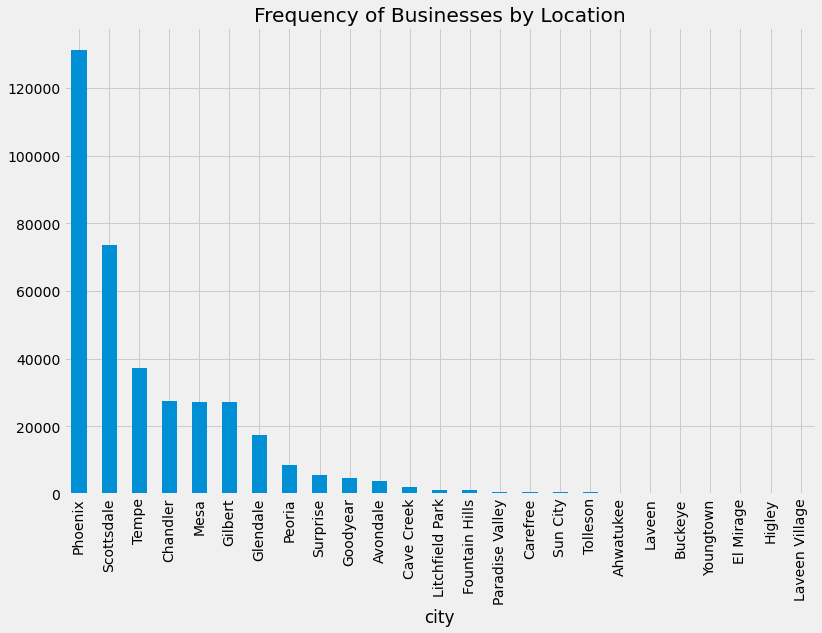

In [62]:
# Let's explore the data further!
# Lets look at our data from a local geographical standpoint to begin.

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 8)

# Number of businesses in each city

df_bus = df_merged.groupby('city').count()
df_bus_city = df_bus['name']
df_bus_sort = df_bus_city.sort_values(ascending = False)
df_bus_sort[:25].plot(kind = 'bar', title = 'Frequency of Businesses by Location')

In [63]:
def num_reviews_per_var(df, group_var, count_var, max_count, title_axis_x, title_axis_y):
    num_review_per_var = df.groupby(group_var, as_index = False).count()[[group_var, count_var]]
    num_review_per_var.columns.values[1] = 'num_reviews_per_var'
    reviews_per_var = num_review_per_var.groupby('num_reviews_per_var', as_index = False).count()
    reviews_per_var.columns.values[1] = 'num_' + group_var
    more_than_x = reviews_per_var[reviews_per_var['num_reviews_per_var'] >= max_count].sum().to_frame().T
    more_than_x['num_reviews_per_var'] = max_count
    reviews_per_var = pd.concat([reviews_per_var[reviews_per_var['num_reviews_per_var'] < max_count], more_than_x]).reset_index(drop = True)
    total_var = reviews_per_var['num_' + group_var].sum()
    reviews_per_var['num_' + group_var] = 100 * reviews_per_var['num_' + group_var] / total_var
    ax = reviews_per_var.plot(x = 'num_reviews_per_var', y = 'num_' + group_var, kind = 'bar')    
    ax.set_ylabel(title_axis_y)
    ax.set_xlabel(title_axis_x)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%2.0f%%'))

In [64]:
import matplotlib.ticker as mtick
sns.set_style("whitegrid")
sns.set_context('paper', rc = {"font.size":20,"axes.titlesize":20, "axes.labelsize":20, "xtick.labelsize":20, "ytick.labelsize":20})

Text(0.5, 1.0, 'Percentage Distribution of Reviews per User')

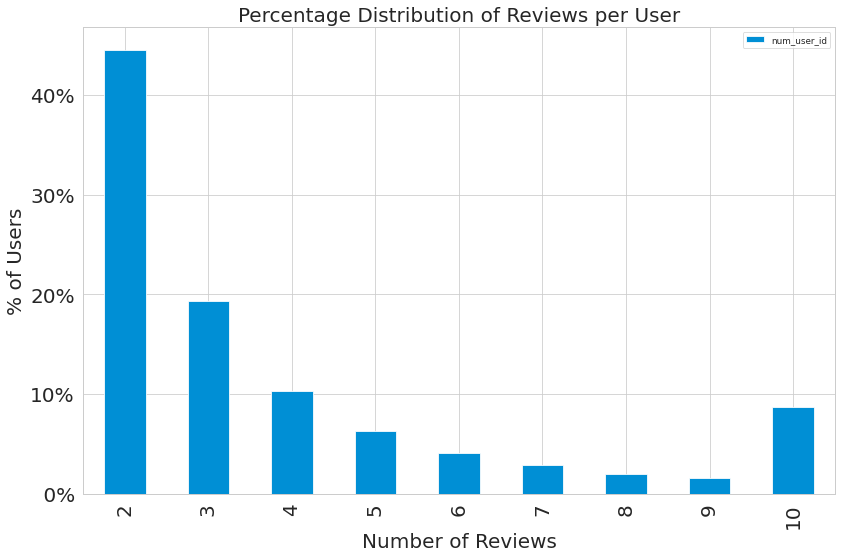

In [65]:
num_reviews_per_var(df_merged, 'user_id', 'review_id', 10, 'Number of Reviews', '% of Users')
plt.title('Percentage Distribution of Reviews per User')

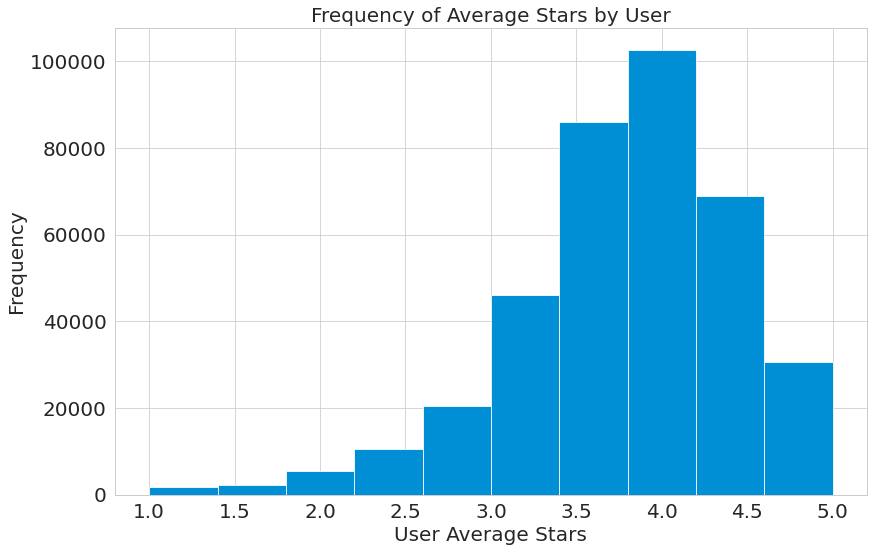

In [66]:
# We can see majority of users only give a couple reviews. This could cause making recommendations difficult as we may not have data for anything that they like
y_user = df_merged['user_average_stars']

fig, ax = plt.subplots(1,1, figsize = (12, 8))
y_user.plot(kind = 'hist', ax = ax)
ax.set_xlabel('User Average Stars')
plt.title('Frequency of Average Stars by User')
plt.show()

In [67]:
print('The average stars given by a user is: {:.4}'.format(y_user.mean()))

The average stars given by a user is: 3.783


Text(0.5, 1.0, 'Percentage Distribution of Reviews per Business')

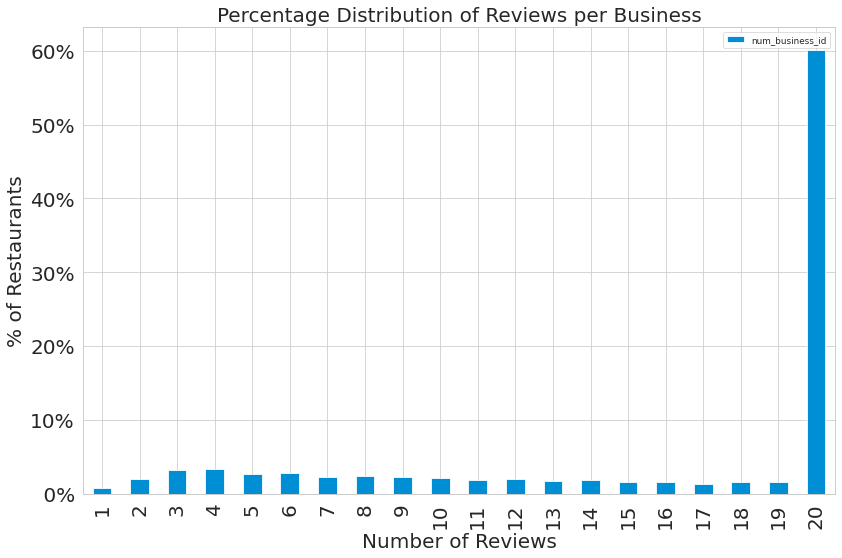

In [68]:
# Something to note here is the potential for user bias as this plot shows that many users tend to give higher ratings than others.

num_reviews_per_var(df_merged, 'business_id', 'review_id', 20, 'Number of Reviews', '% of Restaurants')
plt.title('Percentage Distribution of Reviews per Business')
# The column for 20 is representative of 20 or more reviews

In [69]:
# Something to note here is the number of restaurants that have more than 20 reviews.
# What about the top restaurant categories?

for index, row in business.iterrows():
    categories1 = row.categories
    categorieslist = [x.strip() for x in categories1.split(',')]
    print(categorieslist)
    if index > 3:
        break

['Active Life', 'Gun/Rifle Ranges', 'Guns & Ammo', 'Shopping']
['Health & Medical', 'Fitness & Instruction', 'Yoga', 'Active Life', 'Pilates']
['Pets', 'Pet Services', 'Pet Groomers']
['Hardware Stores', 'Home Services', 'Building Supplies', 'Home & Garden', 'Shopping']
['Home Services', 'Plumbing', 'Electricians', 'Handyman', 'Contractors']


In [70]:
# we calculated the count in categories from before
c.most_common(50)

[('Restaurants', 3749),
 ('Food', 2989),
 ('Fast Food', 1034),
 ('Sandwiches', 746),
 ('Breakfast & Brunch', 692),
 ('Coffee & Tea', 634),
 ('American (Traditional)', 530),
 ('Burgers', 510),
 ('Mexican', 504),
 ('Nightlife', 459),
 ('American (New)', 453),
 ('Bars', 432),
 ('Desserts', 386),
 ('Specialty Food', 368),
 ('Bakeries', 345),
 ('Pizza', 341),
 ('Event Planning & Services', 326),
 ('Salad', 318),
 ('Cafes', 306),
 ('Ice Cream & Frozen Yogurt', 298),
 ('Beer', 283),
 ('Wine & Spirits', 283),
 ('Caterers', 277),
 ('Juice Bars & Smoothies', 276),
 ('Delis', 267),
 ('Italian', 223),
 ('Food Trucks', 221),
 ('Chicken Wings', 211),
 ('Tacos', 178),
 ('Food Delivery Services', 162),
 ('Seafood', 151),
 ('Gluten-Free', 142),
 ('Vegetarian', 123),
 ('Asian Fusion', 119),
 ('Vegan', 116),
 ('Ethnic Food', 115),
 ('Comfort Food', 110),
 ('Grocery', 106),
 ('Chinese', 105),
 ('Hot Dogs', 104),
 ('Barbeque', 103),
 ('Mediterranean', 100),
 ('Wine Bars', 95),
 ('Sports Bars', 93),
 ('Bage

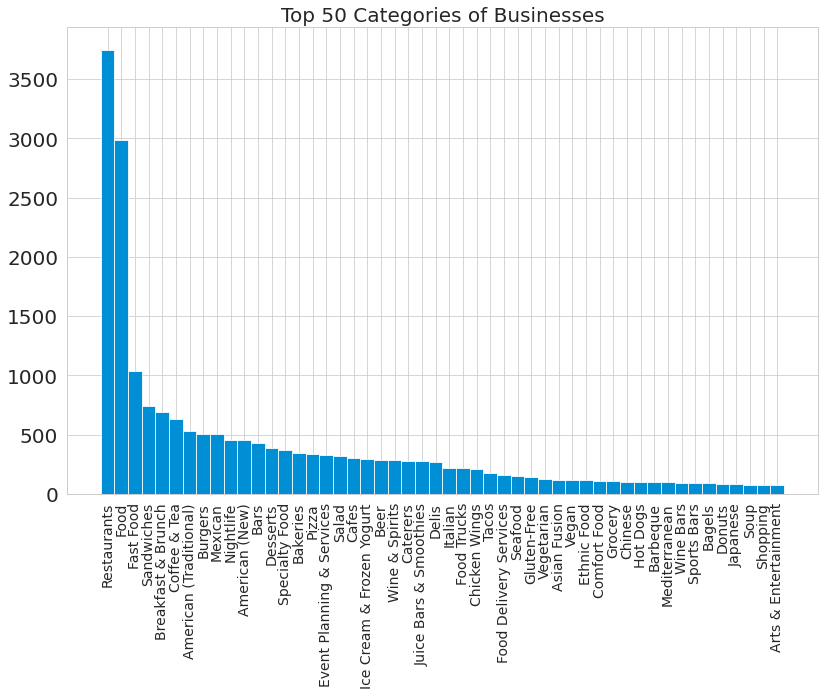

In [72]:
x = c.most_common(50)

labels, ys = zip(*x)
xs = np.arange(len(labels))
width = 1

plt.bar(xs, ys, width, align = 'center')
plt.title('Top 50 Categories of Businesses')
plt.xticks(xs, labels, fontsize = 14, rotation = 90)
plt.show()

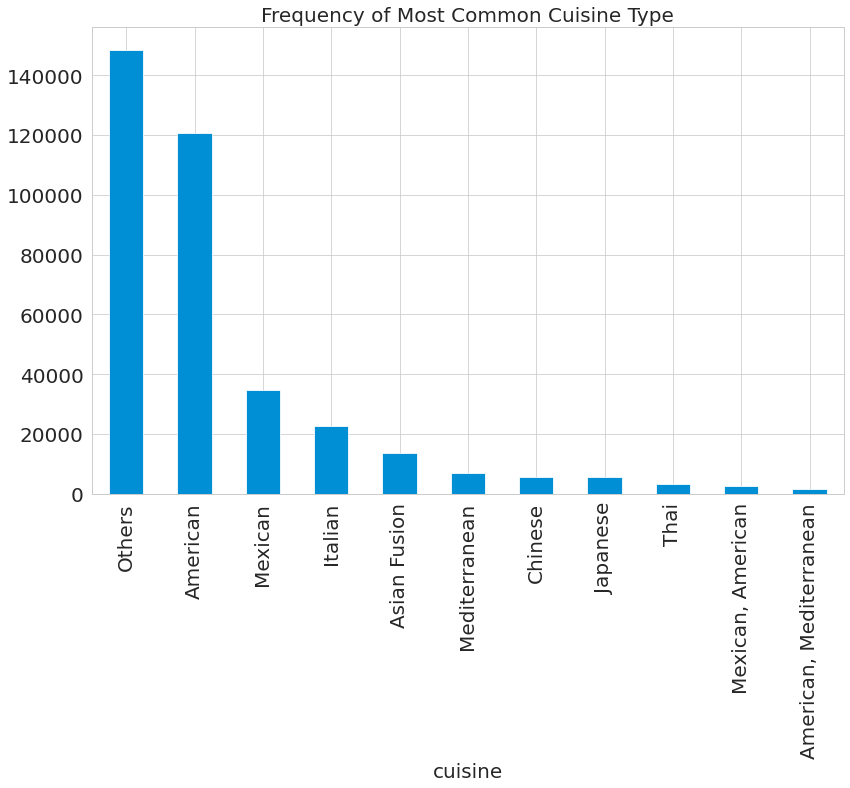

In [73]:
# Lets look at the most common cuisine types

df_cuisine = df_merged.groupby('cuisine').count()
df_cuisine_type = df_cuisine['name']
df_cuisine_sorted = df_cuisine_type.sort_values(ascending = False)
df_cuisine_sorted[:11].plot(kind = 'bar', title = 'Frequency of Most Common Cuisine Type')

In [74]:
# Lets look closer at the information we have at our disposal
# define target variable
target = (df_merged['review_stars'].values)
target = target.astype(int)
target.shape

(374034,)

In [75]:
# To be implemented
print('Statistics of the target variable')
print('Median value: %f' % (np.median(target)))
print('Mean value: %f' % (np.mean(target)))
print('Standard deviation value: %f' % (np.std(target)))

Statistics of the target variable
Median value: 4.000000
Mean value: 3.764607
Standard deviation value: 1.394556


In [76]:
num_users = len(df_merged['user_id'].unique())
num_items = len(df_merged['review_id'].unique())

print("Number of users : {}".format(num_users))
print("Number of reviews : {}".format(num_items))
print("Number of ratings  : {}".format(len(df_merged)))

Number of users : 77158
Number of reviews : 374034
Number of ratings  : 374034


In [77]:
# turn each reviewer and product into categorical data,
df_merged['user_id'] = df_merged['user_id'].astype("category")
df_merged['business_id'] = df_merged['business_id'].astype("category")

In [78]:
reviews_matrix = csc_matrix((df_merged['review_stars'].astype(float),
                            (df_merged['user_id'].cat.codes,
                            df_merged['business_id'].cat.codes)))
reviews_matrix.shape

(77158, 4967)

In [79]:
sparsity = float(len(reviews_matrix.nonzero()[0]))
sparsity /= (reviews_matrix.shape[0] * reviews_matrix.shape[1])
sparsity *= 100
print("Sparsity: {:4.2f}%".format(sparsity))

Sparsity: 0.09%


In [ ]:
# You can see this is extremely sparse. After working with this and trying to build multiple variations of collaborative and content based models,
# there was no success. From here, we aimed to answer two different questions using classification systems